## Examining CU1/SD1 demographics and lab results

Allen Institute for Immunology  
Lucas T. Graybuck  
2021-04-09  

### Purpose

In this notebook, we'll demonstrate how to retrieve stored donor demographics and lab results from HISE for summaries and to answer some questions about lab results.

At this time, our HISE queries are file-centric. This means that any samples that haven't been processed through our data collection and analysis pipelines won't appear in our searches. We hope to have searches in the future that will include all donors. For this demonstration, we'll look for donors that have Flow Cytometry Supervised Statistics results ("FlowCytometry-supervised-stats"), which are gate counts from our supervised gating pipelines.

First, we'll load in a few packages:
- `hise`: Our package for the HISE SDK that connects us to our datasets
- `dplyr`: A package for tabular data manipulation
- `purrr`: A package for manipulating list-structured data
- `ggplot2`: A plotting package which we'll use at the end of the notebook.

In [1]:
library(hise)
library(dplyr)
library(purrr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




We'll also add this helper function, which will soon be integrated into `hise`:

In [2]:
fileDescToDataframe <- function(descriptors,
                                keep_labs = FALSE) {
  
  assertthat::assert_that(typeof(descriptors) == "list")
  assertthat::assert_that(typeof(keep_labs) == "logical")
  
  do.call(
    rbind,
    lapply(
      descriptors,
      function(desc) {
        desc <- unlist(desc)
        desc <- desc[!grepl("scheme", names(desc))]
        names(desc) <- sub("^descriptors.","",names(desc))
        if(!keep_labs) {
          desc <- desc[!grepl("^lab", names(desc))]
        }
        desc <- as.list(desc)
        df <- as.data.frame(desc)
        df
      }
    )
  )
}

### Querying HISE

Next, we'll query HISE using a couple of filters, which we provide as a `list` object:
- `cohort.cohortGuid`: The cohort Globally Unique Identifier ("CU1" for Colorado samples, and "SD1" for San Diego samples)
- `file.panel`: The Flow cytometry panel. Today, we'll look for "PS1" = Panel Survey 1

Once we've specified these filters, we'll pass this to the `getFileDescriptors` function from `hise`, and simplify the results with the `fileDescToDataframe` function:

In [3]:
cu1_filter_list <- list(
    cohort.cohortGuid = "CU1",
    file.panel = "PS1"
)

cu1_desc <- getFileDescriptors(
    fileType = "FlowCytometry-supervised-stats", 
    filter = cu1_filter_list)

cu1_desc_df <- fileDescToDataframe(cu1_desc)

In [4]:
sd1_filter_list <- list(
    cohort.cohortGuid = "SD1",
    file.panel = "PS1"
)

sd1_desc <- getFileDescriptors(
    fileType = "FlowCytometry-supervised-stats", 
    filter = sd1_filter_list)

sd1_desc_df <- fileDescToDataframe(sd1_desc)

We can then join both of these tables together with `rbind`

In [5]:
desc <- rbind(cu1_desc_df, sd1_desc_df)

and see what columns are available with `names`

In [6]:
names(desc)

[1] "lastUpdated"                "sample.id"                 
 [3] "sample.bridgingControl"     "sample.sampleKitGuid"      
 [5] "sample.visitName"           "sample.drawDate"           
 [7] "sample.daysSinceFirstVisit" "file.id"                   
 [9] "file.name"                  "file.batchID"              
[11] "file.panel"                 "file.pool"                 
[13] "file.fileType"              "subject.id"                
[15] "subject.biologicalSex"      "subject.birthYear"         
[17] "subject.ethnicity"          "subject.partnerCode"       
[19] "subject.race"               "subject.subjectGuid"       
[21] "cohort.cohortGuid"

`nrow` will tell us how many records were found:

In [7]:
nrow(desc)

[1] 97

### Sample and subject summaries

To get a better sense of the available datasets, let's select information relevant to samples or subjects using `dplyr`, remove any duplicates from extra files or multiple runs, then summarise some of these metadata:

In [8]:
subject_sample_desc <- desc %>%
  select(starts_with("subject"), starts_with("sample")) %>%
  unique()

How many samples to we have for each subject, and which time points? Tabulating with the `table` function over `sample.visitName` and `subject.subjectGuid` will give us a look:

In [9]:
table(subject_sample_desc$subject.subjectGuid)


CU1001 CU1002 CU1003 CU1004 CU1005 CU1006 CU1007 CU1008 CU1009 CU1010 CU1012 
     4      6      6      4      4      3      4      4      1      1      1 
CU1013 CU1014 CU1016 CU1017 CU1018 CU1019 CU1020 CU1021 CU1022 CU1023 CU1024 
     4      1      2      4      4      4      3      4      4      1      1 
CU1026 CU1027 CU1028 CU1030 CU1031 CU1032 CU1033 CU1034 SD1003 SD1006 
     2      3      3      1      1      2      2      2      3      1 

In [10]:
table(subject_sample_desc$sample.visitName)


      Flu Year 1 Day 0       Flu Year 1 Day 7      Flu Year 1 Day 90 
                    20                     17                      5 
Flu Year 1 Stand-Alone       Flu Year 2 Day 0       Flu Year 2 Day 7 
                    27                      8                      6 
Flu Year 2 Stand-Alone 
                     7 

In [11]:
table(
    subject_sample_desc$subject.subjectGuid,
    subject_sample_desc$sample.visitName
) %>%
  as.data.frame() %>%
  tidyr::pivot_wider(id_cols = Var1,
                     names_from = Var2,
                     values_from = Freq)

Var1,Flu Year 1 Day 0,Flu Year 1 Day 7,Flu Year 1 Day 90,Flu Year 1 Stand-Alone,Flu Year 2 Day 0,Flu Year 2 Day 7,Flu Year 2 Stand-Alone
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
CU1001,1,1,1,0,0,0,1
CU1002,1,1,1,0,1,1,1
CU1003,1,1,1,0,1,1,1
CU1004,1,0,1,0,1,0,1
CU1005,1,0,0,0,1,1,1
CU1006,0,0,0,0,1,1,1
CU1007,1,0,1,0,1,1,0
CU1008,1,1,0,0,1,1,0
CU1009,0,0,0,1,0,0,0


In [12]:
sample_desc <- desc %>%
  select(starts_with("sample")) %>%
  unique()

nrow(sample_desc)

[1] 90

### Sample summaries

Next, let's take a look at available samples:

In [13]:
sample_desc <- desc %>%
  select(starts_with("sample")) %>%
  unique()

nrow(sample_desc)

[1] 90

For example, we may want to know how many samples we have in the bank for baseline ("Flu Year 1 Day 0"), or post-vaccination ("Flu Year 1 Day 7"):

In [14]:
sample_desc %>%
  summarise(
      n_baseline = sum(sample.visitName == "Flu Year 1 Day 0"),
      n_visit2 = sum(sample.visitName == "Flu Year 1 Day 7"))

n_baseline,n_visit2
<int>,<int>
20,17


### Subject summaries

Subject metadata contains several useful demographics. Let's take a look at the composition of our donors:

In [15]:
subjects <- desc %>%
  select(starts_with("subject")) %>%
  unique()

How many donors do we have for each race and ethnicity?

In [16]:
table(subjects$subject.race,
      subjects$subject.ethnicity)

                  
                   Hispanic or Latino origin non-Hispanic origin
  African American                         0                   3
  American Indian                          1                   0
  Caucasian                                0                  27
  Other                                    1                   0

Or each race and sex?

In [17]:
table(subjects$subject.race, 
      subjects$subject.biologicalSex)

                  
                   Female Male
  African American      3    0
  American Indian       1    0
  Caucasian            21    6
  Other                 1    0

How about non-count metrics, like the mean age, fraction female, and fraction of donors that are non-hispanic and caucasian?

In [18]:
subjects %>%
  summarise(
      mean_age = mean(2020 - as.numeric(subject.birthYear)),
      median_age = median(2020 - as.numeric(subject.birthYear)),
      fraction_female = sum(subject.biologicalSex == "Female") / n(),
      fraction_nonhisp_caucasian = sum(subject.race == "Caucasian" & subject.ethnicity == "non-Hispanic origin") / n()
  )

mean_age,median_age,fraction_female,fraction_nonhisp_caucasian
<dbl>,<dbl>,<dbl>,<dbl>
58.46875,60.5,0.8125,0.84375


A histogram of ages may give us a more complete picture of the cohort:

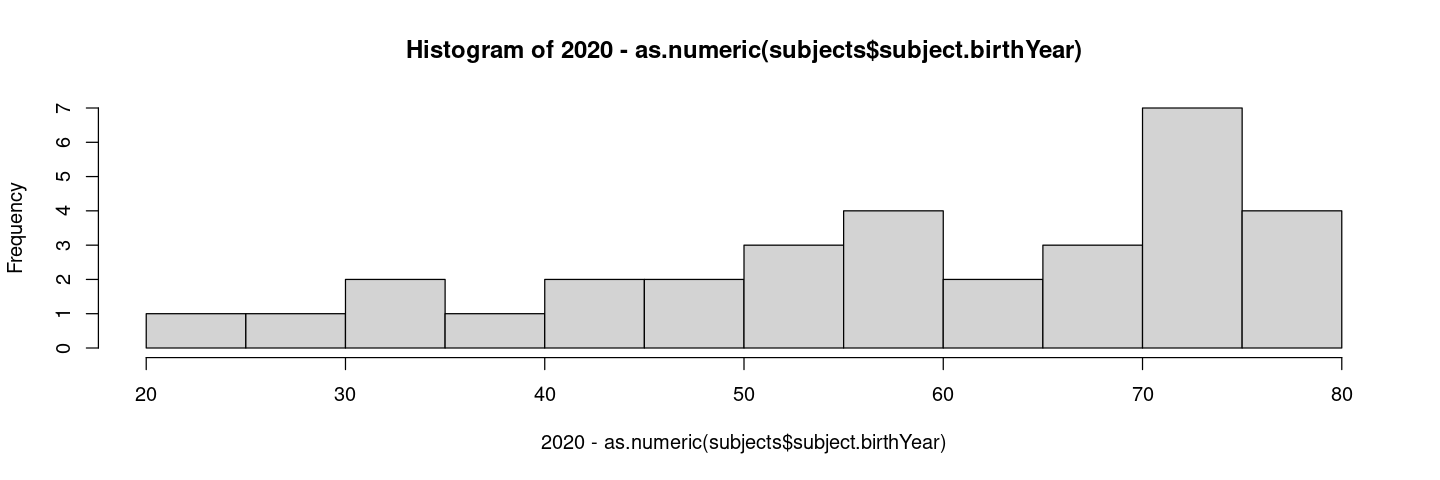

In [19]:
options(repr.plot.width = 12, repr.plot.height = 4)

hist(2020 - as.numeric(subjects$subject.birthYear), breaks = 10)

### Lab results

We can also examine lab results from our donors. These are retrieved along with each file descriptor, but not all samples end up with every result which makes them a little tricky to globally joint together.

Instead, what we can do is specify some results that we're most interested in, then filter the results to answer our biological questions.

First, let's look at one sample to see the results attached to it:

In [20]:
names(cu1_desc[[1]]$lab)

[1] "% Basophils"                                                       
 [2] "% Eosinophils"                                                     
 [3] "% Immature Granulocytes"                                           
 [4] "% Lymphocytes"                                                     
 [5] "% Monocytes"                                                       
 [6] "% Neutrophils"                                                     
 [7] "% Nucleated Red Blood Cells (NRBC)"                                
 [8] "% Segmented Neutrophils"                                           
 [9] "Absolute Basophil Count"                                           
[10] "Absolute Eosinophil Count (AEC)"                                   
[11] "Absolute Immature Granulocyte Count"                               
[12] "Absolute Lymphocyte Count (ALC)"                                   
[13] "Absolute Monocyte Count (AMC)"                                     
[14] "Absolute Neutrophil Count (ANC)"                                   
[15] "Alanine Transaminase (ALT)"                                        
[16] "Albumin"                                                           
[17] "Albumin (Serum Protein Electrophoresis)"                           
[18] "Alkaline Phosphatase"                                              
[19] "Alpha 1 (Serum Protein Electrophoresis)"                           
[20] "Alpha 2 (Serum Protein Electrophoresis)"                           
[21] "Anion Gap"                                                         
[22] "Anti-CCP3"                                                         
[23] "Anti-CCP31"                                                        
[24] "Aspartate Aminotransferase (AST)"                                  
[25] "Beta (Serum Protein Electrophoresis)"                              
[26] "Beta 2 Microglobulin"                                              
[27] "Bilirubin, Total (T-Bili)"                                         
[28] "Blood Urea Nitrogen (BUN)"                                         
[29] "C-Reactive Protein (CRP)"                                          
[30] "C-Rreactive Protein, High-Sensitivity (HS-CRP)"                    
[31] "CMV IgG Serology"                                                  
[32] "Calcium"                                                           
[33] "Carbon Dioxide (CO2)"                                              
[34] "Chloride (Cl)"                                                     
[35] "Cholesterol, HDL"                                                  
[36] "Cholesterol, LDL"                                                  
[37] "Cholesterol, Non-HDL"                                              
[38] "Cholesterol, Total"                                                
[39] "Cholesterol/HDL Ratio"                                             
[40] "Creatinine"                                                        
[41] "Estimated Glomerular Filtration Rate (eGFR) - African American"    
[42] "Estimated Glomerular Filtration Rate (eGFR) - Non-African American"
[43] "Gamma (Serum Protein Electrophoresis)"                             
[44] "Globin"                                                            
[45] "Glucose"                                                           
[46] "Height"                                                            
[47] "Hematocrit"                                                        
[48] "Hemoglobin"                                                        
[49] "Hip size"                                                          
[50] "Immunofixation"                                                    
[51] "Immunoglobulin A"                                                  
[52] "Immunoglobulin G"                                                  
[53] "Immunoglobulin M"                                                  
[54] "Interpretation (Serum Protein Electrophoresis)"                    
[55] 

For these samples, let's look at lab results related to CCP3 and Rheumatoid factor:

In [21]:
get_labs <- c("Anti-CCP3","Anti-CCP31","Rheumatoid Factor, IgA", "Rheumatoid Factor, IgM")

Then, we can filter the descriptors, and convert to a data.frame as before:

In [22]:
cu1_desc_labs <- map(
    cu1_desc,
    function(desc) {
        desc$lab <- desc$lab[get_labs]
        desc
    }
)

In [23]:
cu1_desc_labs_df <- fileDescToDataframe(cu1_desc_labs, keep_labs = TRUE)

In [24]:
sd1_desc_labs <- map(
    sd1_desc,
    function(desc) {
        desc$lab <- desc$lab[get_labs]
        desc
    }
)

In [25]:
sd1_desc_labs_df <- fileDescToDataframe(sd1_desc_labs, keep_labs = TRUE)

In [26]:
desc_labs_df <- rbind(cu1_desc_labs_df,
                      sd1_desc_labs_df)

In [27]:
nrow(desc_labs_df)

[1] 97

Again, we may have a few duplicates, so let's filter these by selecting sample, subject, and lab results:

In [28]:
desc_labs_df <- desc_labs_df %>%
  select(starts_with("sample"),starts_with("subject"), starts_with("lab")) %>%
  unique()

In [29]:
nrow(desc_labs_df)

[1] 90

In [30]:
head(desc_labs_df)

,sample.id,sample.bridgingControl,sample.sampleKitGuid,sample.visitName,sample.drawDate,sample.daysSinceFirstVisit,subject.id,subject.biologicalSex,subject.birthYear,subject.ethnicity,subject.partnerCode,subject.race,subject.subjectGuid,lab.Anti.CCP3,lab.Anti.CCP31,lab.Rheumatoid.Factor..IgA,lab.Rheumatoid.Factor..IgM,labDisplay.version
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,cf1e0551-0a69-4f13-a2b8-c81113d1e3dc,false,KT00067,Flu Year 1 Stand-Alone,2020-01-01T00:00:00Z,0,18ddbec1-5f99-4d03-84e6-3c0c29bbcf75,Female,1946,non-Hispanic origin,CU,Caucasian,CU1019,30,,0.25,0.25,1
2,c768b123-ca74-4e6d-aec0-964a0dd8c833,false,KT00090,Flu Year 1 Stand-Alone,2020-01-01T00:00:00Z,0,7bd0931f-ed24-497f-909e-d73ba41712f6,Female,1947,non-Hispanic origin,CU,Caucasian,CU1024,47,,0.25,0.25,1
3,748de27e-346b-40f4-aafb-c1a751de73e9,false,KT00068,Flu Year 1 Stand-Alone,2020-01-01T00:00:00Z,0,6fa3e8ca-4307-4f9a-8e53-6ca228c23cb8,Female,1965,non-Hispanic origin,CU,Caucasian,CU1020,147,,0.25,3.84,1
4,7f751246-562a-4e73-bba5-cdedaf282dc4,false,KT00073,Flu Year 1 Stand-Alone,2020-01-01T00:00:00Z,0,26c16eb3-4ff5-4a8d-ac1f-895e7de84093,Female,1949,non-Hispanic origin,CU,Caucasian,CU1022,64,,11.41,3.09,1
5,2165e901-5141-4f4a-a553-dbc81af62010,false,KT00095,Flu Year 1 Stand-Alone,2020-02-01T00:00:00Z,0,7a80e45d-f3ca-400d-a4af-e764fc6b282c,Female,1970,non-Hispanic origin,CU,African American,CU1027,49,,0.25,26.21,1
6,ba558f82-05db-4c5d-b6f9-53787f161be1,false,KT00087,Flu Year 1 Stand-Alone,2020-02-01T00:00:00Z,0,3e3bd788-ece3-4a61-b6a6-9464b898361e,Female,1948,non-Hispanic origin,CU,Caucasian,CU1030,52,,0.35,0.25,1


Now that we have them, we can check out some simple plots for these results:

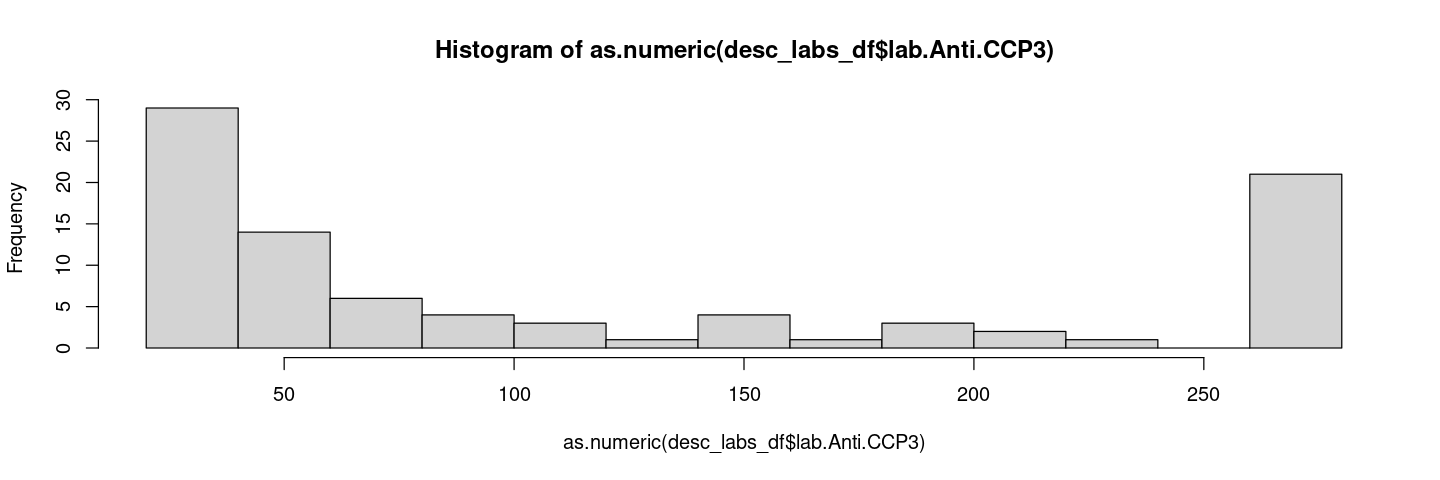

In [31]:
options(repr.plot.width = 12, repr.plot.height = 4)

hist(as.numeric(desc_labs_df$lab.Anti.CCP3), breaks = 10)

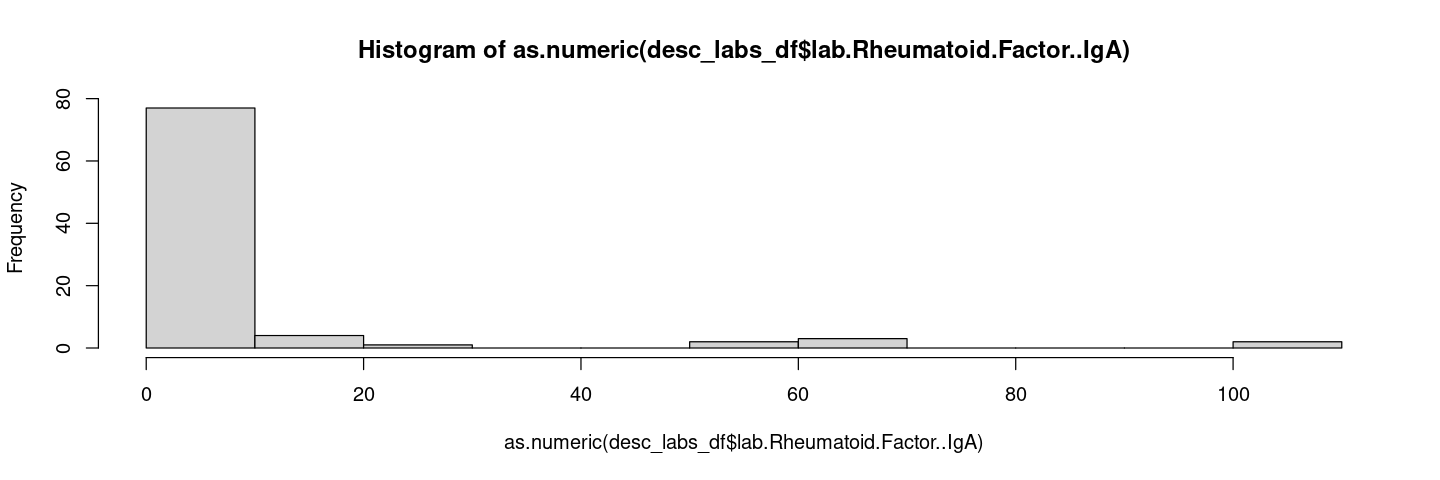

In [32]:
options(repr.plot.width = 12, repr.plot.height = 4)

hist(as.numeric(desc_labs_df$lab.Rheumatoid.Factor..IgA), breaks = 10)

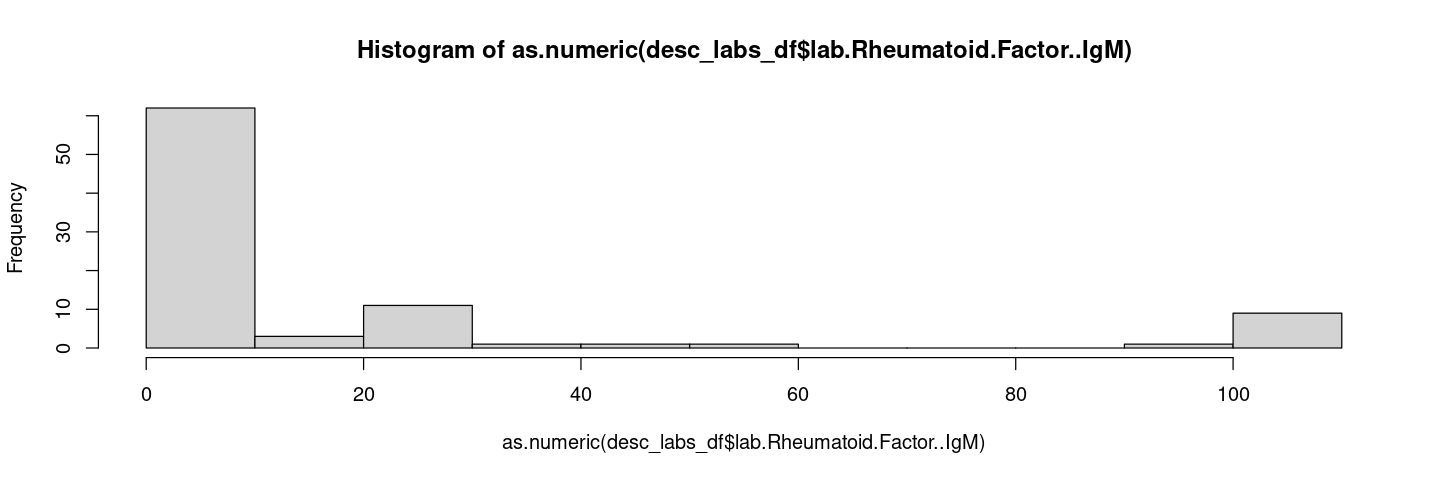

In [33]:
options(repr.plot.width = 12, repr.plot.height = 4)

hist(as.numeric(desc_labs_df$lab.Rheumatoid.Factor..IgM), breaks = 10)

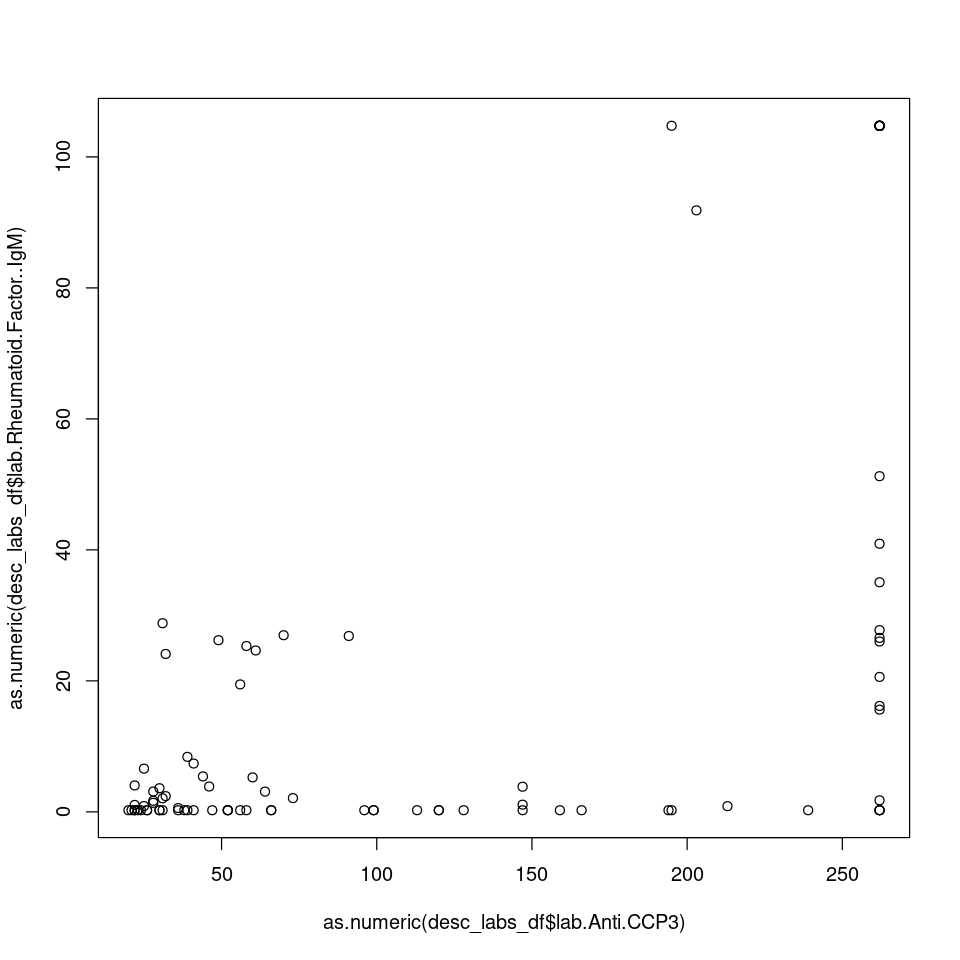

In [37]:
options(repr.plot.width = 8, repr.plot.height = 8)

plot(as.numeric(desc_labs_df$lab.Anti.CCP3),
     as.numeric(desc_labs_df$lab.Rheumatoid.Factor..IgM))

With `ggplot2`, we can make some more advanced, subset plots:

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


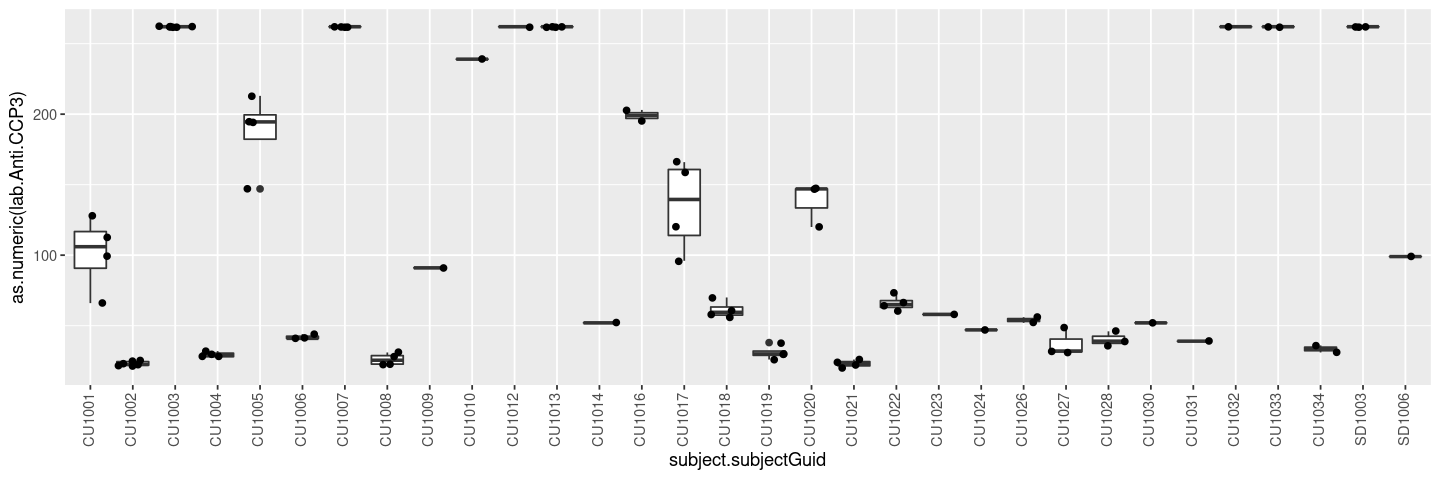

In [38]:
options(repr.plot.width = 12, repr.plot.height = 4)

ggplot() +
  geom_boxplot(
      data = desc_labs_df,
      aes(x = subject.subjectGuid,
          y = as.numeric(lab.Anti.CCP3))
  ) +
  geom_jitter(
      data = desc_labs_df,
      aes(x = subject.subjectGuid,
          y = as.numeric(lab.Anti.CCP3))
  ) +
  theme(axis.text.x = element_text(angle = 90,
                                   hjust = 1,
                                   vjust = 0.3))

In [39]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.3.3 purrr_0.3.4   dplyr_1.0.4   hise_1.0.3   

loaded via a namespace (and not attached):
 [1] pillar_1.5.1      compiler_4.0.2    bitops_1.0-6      base64enc_0.1-3  
 [5] tools_4.0.2       digest_0.6.27     uuid_0.1-4        jsonlite_1.7.2   
 [9] evaluate_0.14     lifecycle_1.0.0   tibble_3.1.0   